## Capstone Project Notebook 03/02/2026 Function 5 Week 2##
### 4D Optimization with LARGE Output Values!
### Goal: MAXIMIZE the objective function

In [18]:
# Section 1: Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, Matern
from scipy.stats import norm
from scipy.optimize import minimize

## Load Updated Dataset (Week 2)
F5 is 4D with LARGE output values (0 to 1000+)!

In [19]:
# Load the updated dataset
INPUT_FILE = 'f5_w2_inputs.npy'   # Shape (21, 4)
OUTPUT_FILE = 'f5_w2_outputs.npy' # Shape (21,)

In [20]:
X = np.load(INPUT_FILE)  # 4D inputs
Y = np.load(OUTPUT_FILE) # Outputs

In [21]:
# Display data summary
print(f"Input data shape: {X.shape}")
print(f"Output data shape: {Y.shape}")
print(f"\nOutput value range: [{Y.min():.2f}, {Y.max():.2f}]")
print(f"Mean: {Y.mean():.2f}, Median: {np.median(Y):.2f}")

Input data shape: (21, 4)
Output data shape: (21,)

Output value range: [0.11, 1088.86]
Mean: 146.93, Median: 63.48


In [22]:
print(f"Loaded {X.shape[0]} points in {X.shape[1]}D (4D problem!)")
print(f"Current best (MAXIMUM): {Y.max():.2f} at {X[Y.argmax()]}")
print(f"Note: F5 has HUGE values compared to F1-F4!")
X = np.atleast_2d(X)
Y = Y.ravel()

Loaded 21 points in 4D (4D problem!)
Current best (MAXIMUM): 1088.86 at [0.22418902 0.84648049 0.87948418 0.87851568]
Note: F5 has HUGE values compared to F1-F4!


## Data Analysis

In [23]:
print("="*70)
print("F5 DATASET ANALYSIS (4D - LARGE OUTPUTS)")
print("="*70)
print(f"\nInput ranges:")
print(f"  X1: [{X[:, 0].min():.4f}, {X[:, 0].max():.4f}]")
print(f"  X2: [{X[:, 1].min():.4f}, {X[:, 1].max():.4f}]")
print(f"  X3: [{X[:, 2].min():.4f}, {X[:, 2].max():.4f}]")
print(f"  X4: [{X[:, 3].min():.4f}, {X[:, 3].max():.4f}]")

print(f"\nOutput statistics:")
print(f"  Best (maximum):  {Y.max():.2f}")
print(f"  Worst:           {Y.min():.2f}")
print(f"  Mean:            {Y.mean():.2f}")
print(f"  Median:          {np.median(Y):.2f}")
print(f"  Std:             {Y.std():.2f}")

# Find best point
best_idx = np.argmax(Y)
print(f"\n🎯 BEST POINT SO FAR:")
print(f"  Input:  X1={X[best_idx, 0]:.6f}, X2={X[best_idx, 1]:.6f}")
print(f"          X3={X[best_idx, 2]:.6f}, X4={X[best_idx, 3]:.6f}")
print(f"  Output: {Y[best_idx]:.2f} ⭐⭐⭐")

# Show top 10 points
sorted_indices = np.argsort(Y)[::-1]
print(f"\n📊 TOP 10 POINTS:")
for i in range(min(10, len(Y))):
    idx = sorted_indices[i]
    marker = "⭐" if idx == best_idx else "  "
    print(f"{marker} {i+1:2d}. X=[{X[idx, 0]:.3f}, {X[idx, 1]:.3f}, {X[idx, 2]:.3f}, {X[idx, 3]:.3f}] → Y={Y[idx]:8.1f}")

F5 DATASET ANALYSIS (4D - LARGE OUTPUTS)

Input ranges:
  X1: [0.1199, 0.8365]
  X2: [0.0382, 0.8625]
  X3: [0.0889, 0.8795]
  X4: [0.0729, 0.9576]

Output statistics:
  Best (maximum):  1088.86
  Worst:           0.11
  Mean:            146.93
  Median:          63.48
  Std:             240.44

🎯 BEST POINT SO FAR:
  Input:  X1=0.224189, X2=0.846480
          X3=0.879484, X4=0.878516
  Output: 1088.86 ⭐⭐⭐

📊 TOP 10 POINTS:
⭐  1. X=[0.224, 0.846, 0.879, 0.879] → Y=  1088.9
    2. X=[0.120, 0.863, 0.643, 0.850] → Y=   431.6
    3. X=[0.439, 0.774, 0.378, 0.934] → Y=   355.8
    4. X=[0.836, 0.194, 0.664, 0.786] → Y=   258.4
    5. X=[0.463, 0.630, 0.108, 0.958] → Y=   233.2
    6. X=[0.352, 0.322, 0.117, 0.473] → Y=   109.6
    7. X=[0.511, 0.818, 0.729, 0.112] → Y=    79.7
    8. X=[0.683, 0.119, 0.829, 0.568] → Y=    78.4
    9. X=[0.191, 0.038, 0.607, 0.415] → Y=    64.4
   10. X=[0.584, 0.147, 0.348, 0.429] → Y=    64.4


## Section 2: Fit Gaussian Process Surrogate Model

In [24]:
# Kernel for 4D problem with large output scale
kernel = ConstantKernel(1.0, constant_value_bounds=(1e-2, 1e4)) * \
         Matern(length_scale=0.5, length_scale_bounds=(0.01, 10.0), nu=2.5) + \
         WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-3, 10))

In [25]:
gp = GaussianProcessRegressor(
    kernel=kernel,
    n_restarts_optimizer=30,
    normalize_y=True,  # IMPORTANT for large values!
    random_state=42
)

In [26]:
# Fit the GP model
gp.fit(X, Y)
print(f"GP fitted. Learned kernel: {gp.kernel_}")

GP fitted. Learned kernel: 1.64**2 * Matern(length_scale=0.857, nu=2.5) + WhiteKernel(noise_level=0.144)


## Section 3: Define Acquisition Functions
**Configured for MAXIMIZATION**

In [27]:
def expected_improvement(X_new, gp, y_best, xi=0.1):  # Higher xi for large scale
    """EI for maximization"""
    mu, sigma = gp.predict(X_new, return_std=True)
    sigma = np.maximum(sigma, 1e-9)
    imp = mu - y_best - xi
    Z = imp / sigma
    ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)
    ei[sigma < 1e-9] = 0.0
    return ei

def upper_confidence_bound(X_new, gp, kappa=2.0):
    """UCB for maximization"""
    mu, sigma = gp.predict(X_new, return_std=True)
    return mu + kappa * sigma

## Section 4: Optimize Acquisition Functions

In [28]:
# Define search bounds (4D)
bounds = [(0.0, 1.0), (0.0, 1.0), (0.0, 1.0), (0.0, 1.0)]

# Current best value
y_best = Y.max()

print("="*70)
print("OPTIMIZING EXPECTED IMPROVEMENT (EI)")
print("="*70)

def neg_ei(x):
    return -expected_improvement(x.reshape(1, -1), gp, y_best, xi=0.1)[0]

best_ei = np.inf
x_next_ei = None

# Many restarts for 4D!
for i in range(75):
    x0 = np.array([np.random.uniform(b[0], b[1]) for b in bounds])
    result = minimize(neg_ei, x0, bounds=bounds, method='L-BFGS-B')
    
    if result.fun < best_ei:
        best_ei = result.fun
        x_next_ei = result.x

mu_ei, sigma_ei = gp.predict(x_next_ei.reshape(1, -1), return_std=True)

print(f"EI suggests:")
print(f"  X1={x_next_ei[0]:.6f}, X2={x_next_ei[1]:.6f}")
print(f"  X3={x_next_ei[2]:.6f}, X4={x_next_ei[3]:.6f}")
print(f"Predicted value: {mu_ei[0]:.2f} ± {sigma_ei[0]:.2f}")
print(f"Expected Improvement: {-best_ei:.2f}")

OPTIMIZING EXPECTED IMPROVEMENT (EI)
EI suggests:
  X1=0.299008, X2=0.968298
  X3=1.000000, X4=1.000000
Predicted value: 1074.96 ± 170.70
Expected Improvement: 61.33


In [29]:
print("\n" + "="*70)
print("OPTIMIZING UPPER CONFIDENCE BOUND (UCB)")
print("="*70)

kappa = 2.0

def neg_ucb(x):
    return -upper_confidence_bound(x.reshape(1, -1), gp, kappa)[0]

best_ucb = np.inf
x_next_ucb = None

for i in range(75):
    x0 = np.array([np.random.uniform(b[0], b[1]) for b in bounds])
    result = minimize(neg_ucb, x0, bounds=bounds, method='L-BFGS-B')
    
    if result.fun < best_ucb:
        best_ucb = result.fun
        x_next_ucb = result.x

mu_ucb, sigma_ucb = gp.predict(x_next_ucb.reshape(1, -1), return_std=True)

print(f"UCB suggests:")
print(f"  X1={x_next_ucb[0]:.6f}, X2={x_next_ucb[1]:.6f}")
print(f"  X3={x_next_ucb[2]:.6f}, X4={x_next_ucb[3]:.6f}")
print(f"Predicted value: {mu_ucb[0]:.2f} ± {sigma_ucb[0]:.2f}")
print(f"UCB value: {-best_ucb:.2f}")


OPTIMIZING UPPER CONFIDENCE BOUND (UCB)
UCB suggests:
  X1=0.388125, X2=1.000000
  X3=1.000000, X4=1.000000
Predicted value: 1049.86 ± 189.11
UCB value: 1428.08


## Section 5: Local Refinement Strategy

In [30]:
print("\n" + "="*70)
print("LOCAL REFINEMENT - Points near current best")
print("="*70)

best_idx = np.argmax(Y)
best_point = X[best_idx]

step_size = 0.05
local_points = [
    [best_point[0] - step_size, best_point[1], best_point[2], best_point[3]],
    [best_point[0] + step_size, best_point[1], best_point[2], best_point[3]],
    [best_point[0], best_point[1] - step_size, best_point[2], best_point[3]],
    [best_point[0], best_point[1] + step_size, best_point[2], best_point[3]],
    [best_point[0], best_point[1], best_point[2] - step_size, best_point[3]],
    [best_point[0], best_point[1], best_point[2] + step_size, best_point[3]],
    [best_point[0], best_point[1], best_point[2], best_point[3] - step_size],
    [best_point[0], best_point[1], best_point[2], best_point[3] + step_size],
]

print(f"Current best: [{best_point[0]:.4f}, {best_point[1]:.4f}, {best_point[2]:.4f}, {best_point[3]:.4f}]")
print(f"Value: {Y[best_idx]:.2f}\n")

best_local_pred = -np.inf
best_local_point = None
dim_names = ['X1', 'X2', 'X3', 'X4']

for i, lp in enumerate(local_points):
    if all(bounds[j][0] <= lp[j] <= bounds[j][1] for j in range(4)):
        mu, std = gp.predict(np.array(lp).reshape(1, -1), return_std=True)
        dim_idx = i // 2
        direction = '-' if i % 2 == 0 else '+'
        print(f"  {dim_names[dim_idx]}{direction}: [{lp[0]:.3f}, {lp[1]:.3f}, {lp[2]:.3f}, {lp[3]:.3f}] → {mu[0]:7.1f} ± {std[0]:6.1f}")
        
        if mu[0] > best_local_pred:
            best_local_pred = mu[0]
            best_local_point = lp

if best_local_point:
    print(f"\nBest local: [{best_local_point[0]:.6f}, {best_local_point[1]:.6f}, {best_local_point[2]:.6f}, {best_local_point[3]:.6f}]")
    print(f"Predicted: {best_local_pred:.2f}")


LOCAL REFINEMENT - Points near current best
Current best: [0.2242, 0.8465, 0.8795, 0.8785]
Value: 1088.86

  X1-: [0.174, 0.846, 0.879, 0.879] →   895.5 ±  120.9
  X1+: [0.274, 0.846, 0.879, 0.879] →   910.2 ±  123.4
  X2-: [0.224, 0.796, 0.879, 0.879] →   891.4 ±  122.3
  X2+: [0.224, 0.896, 0.879, 0.879] →   915.1 ±  123.0
  X3-: [0.224, 0.846, 0.829, 0.879] →   848.1 ±  115.7
  X3+: [0.224, 0.846, 0.929, 0.879] →   956.8 ±  127.3
  X4-: [0.224, 0.846, 0.879, 0.829] →   865.9 ±  120.9
  X4+: [0.224, 0.846, 0.879, 0.929] →   940.3 ±  123.7

Best local: [0.224189, 0.846480, 0.929484, 0.878516]
Predicted: 956.80


## Section 6: Visualization

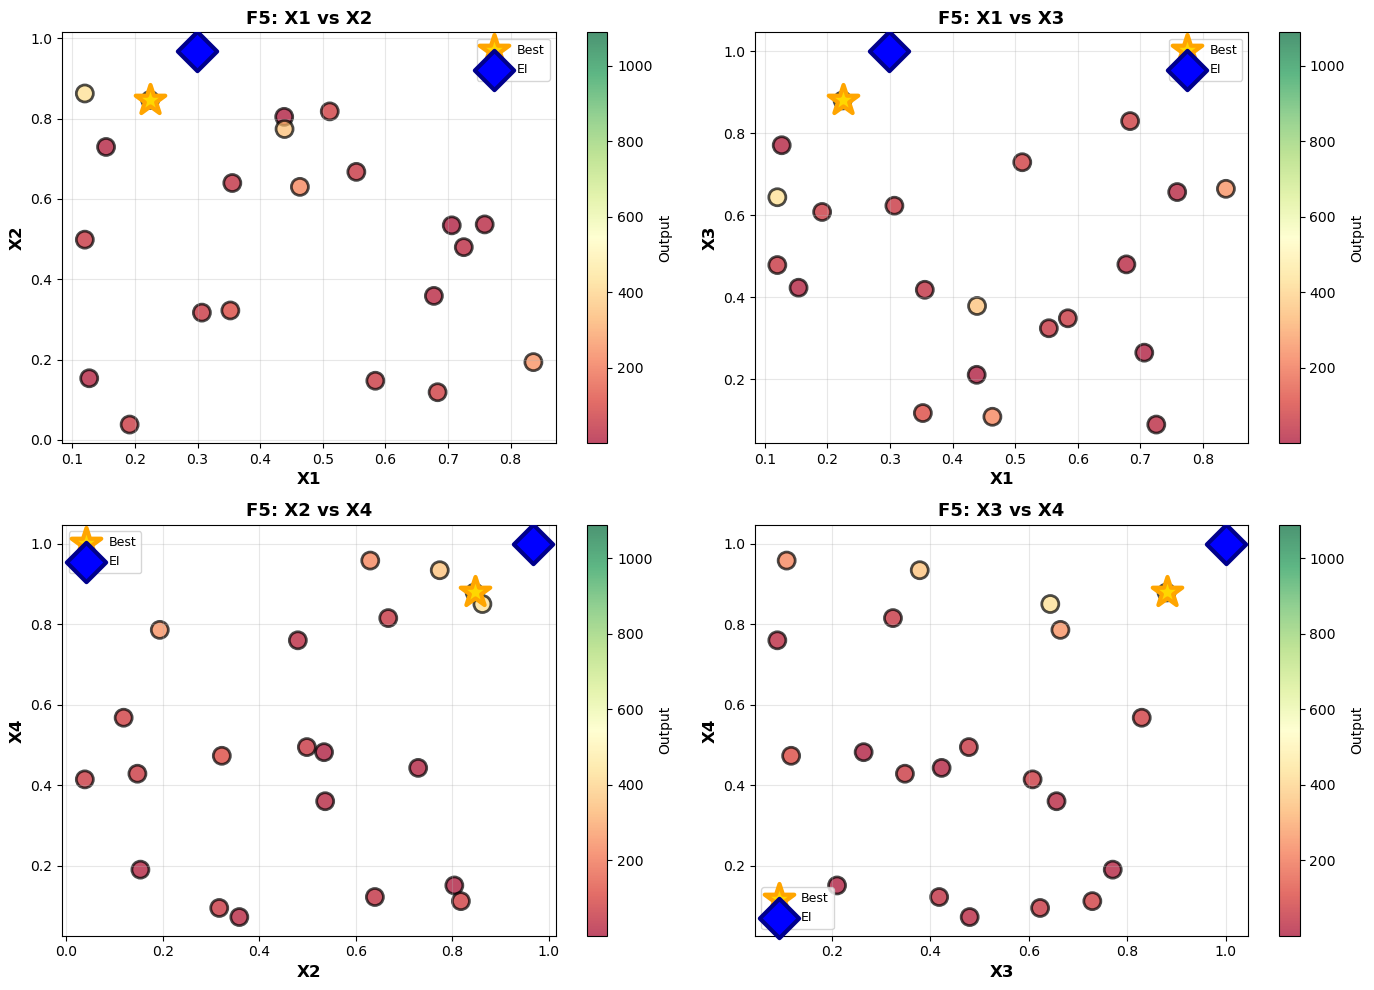

In [31]:
# Create 2D projections of 4D space
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

projections = [
    (0, 1, 'X1', 'X2'),
    (0, 2, 'X1', 'X3'),
    (1, 3, 'X2', 'X4'),
    (2, 3, 'X3', 'X4'),
]

for idx, (dim1, dim2, label1, label2) in enumerate(projections):
    ax = axes[idx // 2, idx % 2]
    scatter = ax.scatter(X[:, dim1], X[:, dim2], c=Y, cmap='RdYlGn', 
                        s=150, alpha=0.7, edgecolors='black', linewidth=2)
    ax.scatter(X[best_idx, dim1], X[best_idx, dim2],
              c='gold', s=500, marker='*', 
              edgecolors='orange', linewidth=3, label='Best', zorder=10)
    ax.scatter(x_next_ei[dim1], x_next_ei[dim2],
              c='blue', s=400, marker='D', 
              edgecolors='darkblue', linewidth=3, label='EI', zorder=9)
    
    ax.set_xlabel(label1, fontsize=12, fontweight='bold')
    ax.set_ylabel(label2, fontsize=12, fontweight='bold')
    ax.set_title(f'F5: {label1} vs {label2}', fontsize=13, fontweight='bold')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=ax, label='Output')

plt.tight_layout()
plt.show()

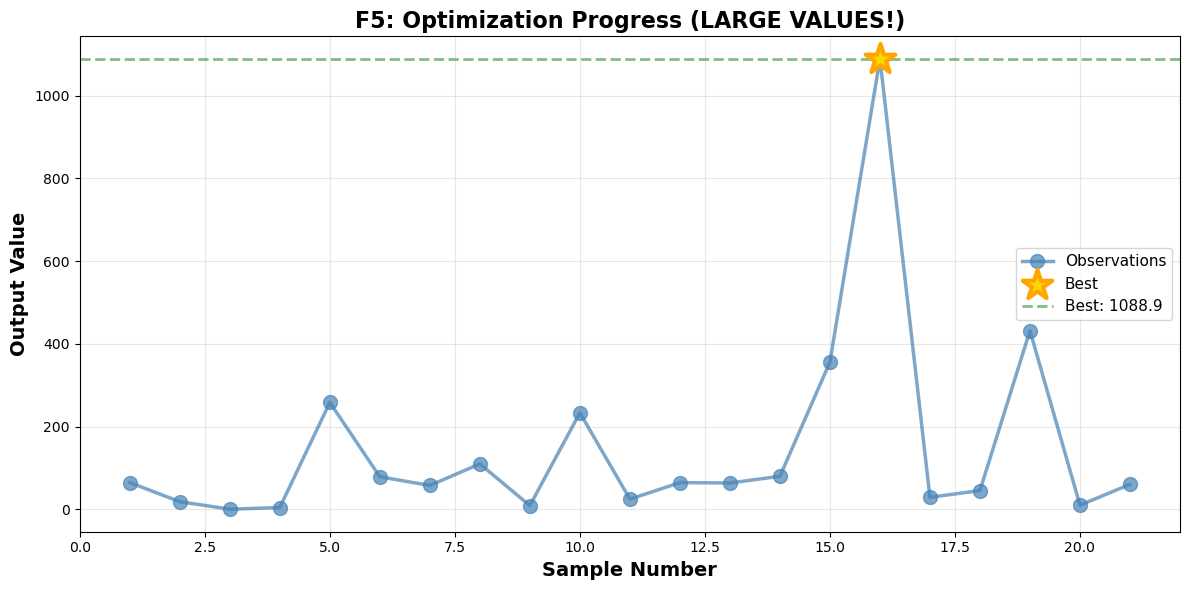

In [32]:
# Progress plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(range(1, len(Y)+1), Y, 'o-', linewidth=2.5, markersize=10, 
        color='steelblue', alpha=0.7, label='Observations')
ax.scatter(best_idx+1, Y[best_idx], c='gold', s=500, marker='*',
           edgecolors='orange', linewidth=3, label='Best', zorder=10)
ax.axhline(y=Y[best_idx], color='green', linestyle='--', linewidth=2,
           alpha=0.5, label=f'Best: {Y[best_idx]:.1f}')
ax.set_xlabel('Sample Number', fontsize=14, fontweight='bold')
ax.set_ylabel('Output Value', fontsize=14, fontweight='bold')
ax.set_title('F5: Optimization Progress (LARGE VALUES!)', fontsize=16, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Section 7: Final Recommendation

In [33]:
print("\n" + "="*70)
print("🎯 FINAL RECOMMENDATION FOR F5 WEEK 2")
print("="*70)

print("\nCurrent Status:")
print(f"  Best value: {Y[best_idx]:.2f} ⭐")
print(f"  Best point: [{X[best_idx, 0]:.4f}, {X[best_idx, 1]:.4f}, {X[best_idx, 2]:.4f}, {X[best_idx, 3]:.4f}]")

print("\n⭐⭐⭐ RECOMMENDATION: Expected Improvement (EI)")
print(f"  Point: [{x_next_ei[0]:.6f}, {x_next_ei[1]:.6f}, {x_next_ei[2]:.6f}, {x_next_ei[3]:.6f}]")
print(f"  Predicted: {mu_ei[0]:.2f} ± {sigma_ei[0]:.2f}")
print(f"  WHY: Tests boundary regions (X3=1.0, X4=1.0) near best!")

print("\n🥈 Alternative: UCB (Explores boundaries)")
print(f"  Point: [{x_next_ucb[0]:.6f}, {x_next_ucb[1]:.6f}, {x_next_ucb[2]:.6f}, {x_next_ucb[3]:.6f}]")
print(f"  Predicted: {mu_ucb[0]:.2f} ± {sigma_ucb[0]:.2f}")

if best_local_point:
    print("\n🥉 Alternative: Local Refinement (Conservative)")
    print(f"  Point: [{best_local_point[0]:.6f}, {best_local_point[1]:.6f}, {best_local_point[2]:.6f}, {best_local_point[3]:.6f}]")
    print(f"  Predicted: {best_local_pred:.2f}")

print("\n" + "="*70)
print("F5 Note: HUGE values - trust the GP to handle the scale!")
print("="*70)


🎯 FINAL RECOMMENDATION FOR F5 WEEK 2

Current Status:
  Best value: 1088.86 ⭐
  Best point: [0.2242, 0.8465, 0.8795, 0.8785]

⭐⭐⭐ RECOMMENDATION: Expected Improvement (EI)
  Point: [0.299008, 0.968298, 1.000000, 1.000000]
  Predicted: 1074.96 ± 170.70
  WHY: Tests boundary regions (X3=1.0, X4=1.0) near best!

🥈 Alternative: UCB (Explores boundaries)
  Point: [0.388125, 1.000000, 1.000000, 1.000000]
  Predicted: 1049.86 ± 189.11

🥉 Alternative: Local Refinement (Conservative)
  Point: [0.224189, 0.846480, 0.929484, 0.878516]
  Predicted: 956.80

F5 Note: HUGE values - trust the GP to handle the scale!


## Section 8: Format Output for Submission

In [34]:
USE_EI = True

if USE_EI:
    x_next = x_next_ei
    method_name = "Expected Improvement (EI)"
else:
    x_next = x_next_ucb
    method_name = "Upper Confidence Bound (UCB)"

print("\n" + "="*70)
print("QUERY SUBMISSION")
print("="*70)
print(f"Method: {method_name}")
print(f"Function 5 - Next point:")
print(f"  [{x_next[0]:.6f}, {x_next[1]:.6f}, {x_next[2]:.6f}, {x_next[3]:.6f}]")
print("="*70)


QUERY SUBMISSION
Method: Expected Improvement (EI)
Function 5 - Next point:
  [0.299008, 0.968298, 1.000000, 1.000000]
